# Mini-Project 3: Classification of Image Data

McGill University


845 Sherbrooke Street West, Montréal (Québec)  H3A 0G4

## 1. Acquiring, preprocessing, and analyzing the data

### 1.1. Loading and looking at data




Importing the required libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

sns.set()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


Importing the CIFAR-10  dataset:


In [0]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [0]:
trainset = CIFAR10(root = './data', train = True, download = True)

trainloader = DataLoader(trainset,
                         batch_size = 4,
                         shuffle = True,
                         num_workers = 2
                         )

testset = CIFAR10(root = './data', train = False, download = True)

testloader = DataLoader(testset,
                        batch_size = 4,
                        shuffle = False,
                        num_workers = 2)

# Classes corresponding to the target values
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Taking a look at first $5$ images of the data train data and their corresponding classes:

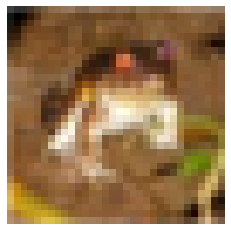


frog


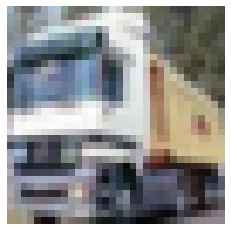

truck


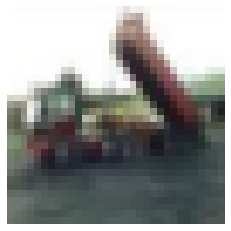

truck


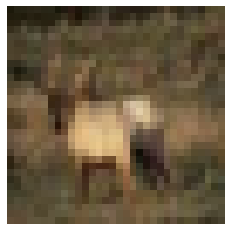

deer


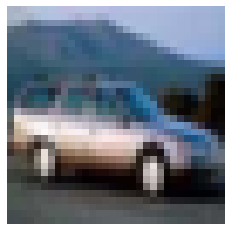

car


In [0]:
for i in range(5):
    plt.imshow(trainset[i][0])

    plt.axis('off')
    plt.grid(b = None)
    
    plt.show()
    print(classes[trainset[i][1]])

### 1.2. Data preprocessing

First, note that every image in the CIFAR-10 dataset has $32 \times 32 \times 3$ or $3072$ features as it is essentially a patch of $32 \times 32$ pixels with $3$ chanels corresponding to fundamental colors: red, green, blue (RGB).

Thus, every image can be considered as a numpy array. It was decided to define the function for data preprocessing separatelly as it shall be used for the testing dataset later.

In [0]:
def preprocessing(dataset):

    print("Converting to numpy arrays...")
    X = []
    y = []

    for i in range(len(trainset)):
        X.append(numpy.asarray(trainset[i][0]))

        y.append(trainset[i][1])
        i += 1

    # considering X and y as numpy arrays
    X = np.asarray(X)
    y = np.asarray(y)

    '''
    Every feature of every image is essentially a value in the interval of
    [0,...,255] . Thus, the data can be normalized according to this:
    '''

    print("Normalizing...")

    X = X / 255.0 # normalizing

    # Getting the number of features and classes:
    n_features = 1
    for d in X[0].shape:
        n_features *= d

    n_classes = len(classes)
    
    # Flattening the data:
    print("Flattening the data...")
    X = X.reshape(-1, n_features, 1)

    # The following section is reserved for the one-hot encoding

    #new_y = np.zeros((y.shape[0], n_classes))
    #new_y[np.arange(y.shape[0]), y] = 1

    #y = new_y.reshape(-1, 10, 1)

    # Removing an unnecessary dimension
    X = np.stqueeze(X)
    y = np.squeeze(y)
    
    print("Done.")
    return X, y

In [0]:
%time X, y = preprocessing(trainset)

Converting to numpy arrays...
Normalizing...
Flattening the data...
Done.
CPU times: user 4.75 s, sys: 638 ms, total: 5.39 s
Wall time: 5.39 s


## 2. Implementing the multilayer perceptron (MLP)

First, we define a layer as a separate class that can provide output according to its input or propogate gradients. An empty layer is defined in such a way that its output is the same with its input. Further inheritance extends the funcitonality of the layer.

In [0]:
class Layer:

    def __init__(self):
        pass
    
    # Implementing the feedforward
    def feedforward(self, x):
        return x

    # Implementing the backpropagation
    def backpropagation(self, x, grad_y):
        n_units = x.shape[1]
        
        grad_layer = np.eye(n_units)

        # By the chain rule:
        return np.dot(grad_y, grad_layer) 

The ReLU funcion is essentially defined as $f(x) = \max(x, 0)$.

In [0]:
class ReLU(Layer):

    def __init__(self):
        pass

    # Implementing the feedforward
    def feedforward(self, x):
        return np.maximum(x, 0)

    # Implementing the backpropagation
    def backpropagation(self, x, grad_y):
        grad_ReLU = x > 0
        return grad_y * grad_ReLU

In this work, fully connected (dense) layers are used, i.e. the layers can be defined as $f(x) = Wx + b$ where $W$ is the weight matrix of the layer, $x$ is its input, and $b$ is the bias.

In [0]:
class Dense(Layer):
    
    def __init__(self,
                 n_x, # number of inputs
                 n_y, # number of outputs
                 lr = 0.01 # learning rate
                 ):
        
        self.lr = lr

        # Weights:
        self.W = np.random.normal(loc = 0.0,
                                  scale = np.sqrt(2 / (n_x + n_y)),
                                  size = (n_x,n_y))
        # Biases:
        self.b = np.zeros(n_y)

    # Implementing the feedforward
    def feedforward(self, x):    

        return np.dot(x, self.W) + self.b
    
    # Implementing the backpropagation with stochastic gradient descent (SGD)
    def backpropagation(self, x, grad_y):
 
        grad_x = np.dot(grad_y, self.W.T)
        
        grad_W = np.dot(x.T, grad_y)
        grad_b = grad_y.mean(axis = 0) * x.shape[0]
        
        assert grad_W.shape == self.W.shape and grad_b.shape == self.b.shape
        
        # SGD step:
        self.W = self.W - self.lr * grad_W
        self.b = self.b - self.lr * grad_b
        
        return grad_x

The multi-layer preceptron is defined as a class in this work. Note that the standard cross entropy loss is used, which is defined as $L_{CE} (y, w^\top x) = -y \log(\hat{y}) - (1 - y) \log(1-\hat{y})$ where $\hat{y}_c = \mathrm{softmax}(x)_c = \frac{e^{z_c}}{\Sigma_{c'=1}^C e^{z_{c'}}}$ and $z = w^\top x$ is a logit, so $\Sigma_c \hat{y} = 1$.

In [0]:
from tqdm import trange
from IPython.display import clear_output

In [0]:
class MLP:

    def __init__(
        self,
        layers, # layers used in MLP
        n_epochs = 15 # number of epochs
        ):

        self.layers = layers
        self.n_epochs = n_epochs


    # Implementing the softmax function:
    def __softmax(self, z):
        return np.exp(z) / np.exp(z).sum(axis = -1, keepdims = True)

    # Implementing the softmax cross-entropy loss function:
    def __loss(self,
               z, # logit
               y # output
               ):
        return - z[np.arange(len(z)), y] + np.log(np.sum(np.exp(z), axis = -1))

    # Implementing the gradient of the loss function:
    def __grad_loss(self,
                    z, # logit
                    y # output
                    ):
      
        yh = self.__softmax(z)

        ones = np.zeros_like(z)
        ones[np.arange(len(z)), y] = 1
        
        return (- ones + yh) / z.shape[0]

    # Implementing the feedforward:
    def __feedforward(self,
                      layers, # all layers
                      x # input
                      ):
      
        hs = [] # activations
        
        for layer in layers:
            hs.append(layer.feedforward(x))
            x = hs[-1]
        
        assert len(hs) == len(layers)
        return hs

    def __iterate_minibatches(self, X, y, batch_size):
        assert len(X) == len(y)
        
        ids = np.random.permutation(len(X))
        for i in trange(0, len(X) - batch_size + 1, batch_size):
            k = ids[i:i + batch_size]
            yield X[k], y[k]

    # Implementing the fit function:
    def fit(self,
            X,
            y
            ):
      
        layer_h = self.__feedforward(self.layers, X)
        layer_x = [X] + layer_h 
        z = layer_h[-1]
        
        # Obtaining the loss
        y = y.astype(int)
        loss = self.__loss(z, y)
        grad_loss = self.__grad_loss(z, y)
        
        # Backpropagation:
        for layer_id in range(len(self.layers))[::-1]:
            layer = self.layers[layer_id]
            
            grad_loss = layer.backpropagation(layer_x[layer_id], grad_loss)
            
        return np.mean(loss)

    # Implementing the predict function
    def predict(self, X):
        z = self.__feedforward(self.layers, X)[-1]
        return z.argmax(axis = -1)

    def evaluate_acc(self, X_train, y_train, X_val, y_val):
        train_log = []
        val_log = []
        for i in range(self.n_epochs):
            for x_batch,y_batch in self.__iterate_minibatches(X_train, y_train, batch_size = 32):
                self.fit(x_batch, y_batch)
            
            train_log.append(np.mean(self.predict(X_train) == y_train))
            val_log.append(np.mean(self.predict(X_val) == y_val))
            
            clear_output()
            print("Epoch", i)
            print("Train accuracy:", train_log[-1])
            print("Val accuracy:", val_log[-1])
            plt.plot(train_log, label = 'train accuracy')
            plt.plot(val_log, label='validation accuracy')
            plt.legend(loc = 'best')
            plt.grid()
            plt.show()
        
        return train_log, val_log

Now, all is set for experiments. First, all layers are defined:




In [0]:
layers = []
layers.append(Dense(X.shape[1], 256))
layers.append(ReLU())
layers.append(Dense(256, 256))
layers.append(ReLU())
layers.append(Dense(256, 10))

layers

Setting up the multi-layer perceptron:

In [0]:
model = MLP(layers = layers, n_epochs = 15)

For the initial test, the last 10 000 training samples are taken for validation

In [0]:
X_train, X_val = X[:-10000], X[-10000:]
y_train, y_val = y[:-10000], y[-10000:]

Epoch 14
Train accuracy: 0.574825
Val accuracy: 0.5103


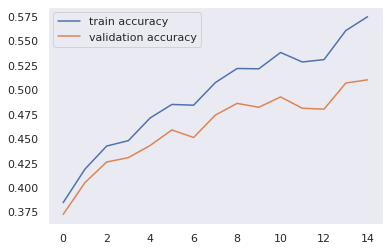

In [0]:
train_log, val_log = model.evaluate_acc(X_train, y_train, X_val, y_val)

### 3. $k$-fold cross-validation

In [0]:
def k_fold_cross_validation(X, # features
                            y, # targets
                            model, #model to validate
                            k = 5 # number of folds
                            ):
    fold_size = int( len(X) / k )
    
    val_acc = []

    for i in range(k):

        # Data split
        X_train, X_val = np.concatenate((X[:i * fold_size], X[(i + 1) * fold_size :])), X[i * fold_size : (i + 1) * fold_size]
        y_train, y_val = np.concatenate((y[:i * fold_size], y[(i + 1) * fold_size :])), y[i * fold_size : (i + 1) * fold_size]

        val_acc.append(np.mean(model.predict(X_val) == y_val))

    print("Average validation accuracy:", np.mean(val_acc))

    return np.mean(val_acc)

In [0]:
val_acc = k_fold_cross_validation(X, y, model, k = 5)

Average validation accuracy: 0.56192


## 4. Testing

Preprocessing the test data:

In [0]:
%time X_test, y_test = preprocessing(testset)

Converting to numpy arrays...
Normalizing...
Flattening the data...
Done.
CPU times: user 4.85 s, sys: 109 ms, total: 4.96 s
Wall time: 4.88 s


In [0]:
print("Accuracy on test data", np.mean(model.predict(X_test) == y_test))

Accuracy on test data 0.56192


## 5. Improving the accuracy

The accuracy of 54.22% obtained in $k$-fold cross-validation calls for a bit of improvement. In attempt to do so, it was decided to apply $k$-fold split for training, i.e. running the training $k=5$ times with 15 epochs on each fold. The idea behind this is that it could help the model respond better on unseen data and make it more adaptive. First, the model is defined again:

In [0]:
model = MLP(layers = layers, n_epochs = 15)

Now, the proposed approach is defined as a separate function:

In [0]:
def k_fold_fit(X, # features
               y, # targets
               model, #model to validate
               k = 5 # number of folds
               ):
    fold_size = int( len(X) / k )

    train_acc = []
    val_acc = []

    for i in range(k):

        # Data split
        X_train, X_val = np.concatenate((X[:i * fold_size], X[(i + 1) * fold_size :])), X[i * fold_size : (i + 1) * fold_size]
        y_train, y_val = np.concatenate((y[:i * fold_size], y[(i + 1) * fold_size :])), y[i * fold_size : (i + 1) * fold_size]

        train_log, val_log = model.evaluate_acc(X_train, y_train, X_val, y_val)
        train_acc.append(train_log[-1])
        val_acc.append(val_log[-1])

    print("Average train accuracy:", np.mean(train_acc))
    print("Average validation accuracy:", np.mean(val_acc))
    return np.mean(train_acc), np.mean(val_acc)

Epoch 14
Train accuracy: 0.8366
Val accuracy: 0.7256


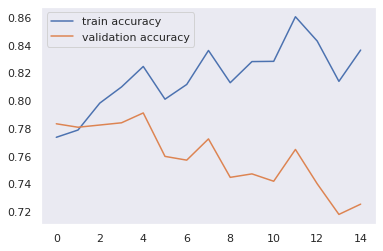

Average train accuracy: 0.7449899999999999
Average validation accuracy: 0.64836


In [0]:
train_acc, val_acc = k_fold_fit(X, y, model, k = 5)

## 6. $k$-fold cross-validation again

In [0]:
val_acc = k_fold_cross_validation(X, y, model, k = 5)

Average validation accuracy: 0.8144


## 7. Testing again

Preprocessing the test data:

In [0]:
%time X_test, y_test = preprocessing(testset)

Converting to numpy arrays...
Normalizing...
Flattening the data...
Done.
CPU times: user 4.89 s, sys: 122 ms, total: 5.01 s
Wall time: 4.94 s


In [0]:
print("Accuracy on test data", np.mean(model.predict(X_test) == y_test))

Accuracy on test data 0.8144
